# Lab 3 Report: 
## MNIST Classification with FCN

### Name:

In [3]:
# Import necessary packages

%matplotlib inline
%pip install torchvision
%pip install numpy

import matplotlib.pyplot as plt

import torch
import torchvision
import numpy as np

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
from IPython.display import Image # For displaying images in colab jupyter cell

In [6]:
Image('lab3_exercise.PNG', width = 1000)

FileNotFoundError: No such file or directory: 'lab3_exercise.PNG'

FileNotFoundError: No such file or directory: 'lab3_exercise.PNG'

<IPython.core.display.Image object>

### Prepare Data

In [39]:
# Load MNIST Dataset in Numpy

# 1000 training samples where each sample feature is a greyscale image with shape (28, 28)
# 1000 training targets where each target is an integer indicating the true digit
mnist_train_features = np.load('mnist_train_features.npy') 
mnist_train_targets = np.load('mnist_train_targets.npy')

# 100 testing samples + targets
mnist_test_features = np.load('mnist_test_features.npy')
mnist_test_targets = np.load('mnist_test_targets.npy')

# Print the dimensions of training sample features/targets
print(mnist_train_features.shape, mnist_train_targets.shape)
# Print the dimensions of testing sample features/targets
print(mnist_test_features.shape, mnist_test_targets.shape)

(1000, 28, 28) (1000,)
(100, 28, 28) (100,)


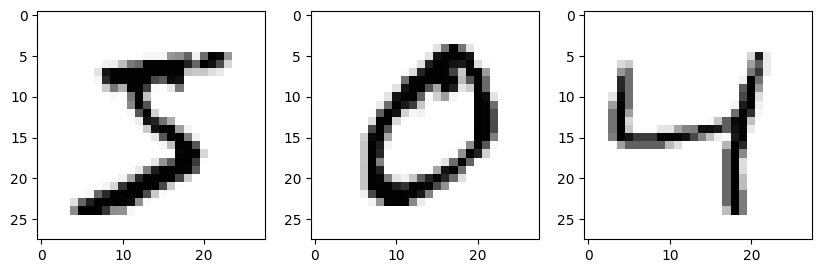

In [40]:
# Let's visualize some training samples

plt.figure(figsize = (10, 10))

plt.subplot(1,3,1)
plt.imshow(mnist_train_features[0], cmap = 'Greys')

plt.subplot(1,3,2)
plt.imshow(mnist_train_features[1], cmap = 'Greys')

plt.subplot(1,3,3)
plt.imshow(mnist_train_features[2], cmap = 'Greys')

In [43]:
# Reshape features via flattening the images
# This refers to reshape each sample from a 2d array to a 1d array.
# hint: np.reshape() function could be useful here

# Reshaping original array into (1000, 784), flatten samples into 1D arrays of 28*28=784 elements, which is for MNIST images
mnist_train_features = np.reshape(mnist_train_features, (1000, 784)) 
mnist_test_features = np.reshape(mnist_test_features, (100, 784)) 


print(mnist_train_features.shape, mnist_test_features.shape)

(1000, 784) (100, 784)


In [47]:

# Initialize the scaler
from sklearn.preprocessing import StandardScaler
# Creates instance of StandardScalar class
scaler = StandardScaler()

# Fit the scaler on the training and test data (calculates mean and standard deviation of each feature, mean=0, s.d=1)
mnist_train_features = scaler.fit_transform(mnist_train_features)
mnist_test_features = scaler.fit_transform(mnist_test_features)




In [49]:
from sklearn.model_selection import train_test_split

# Creates validation set by taking the first 100 elements of the training features and targets sets
# validation setuseful for assessing model performance during training
mnist_validation_features = mnist_train_features[:100]
mnist_validation_targets = mnist_train_targets[:100]

# creates training set by taking last 100 elements of training features and target --> unseen validation set
# used for "unbiased" understanding of the model performacne
mnist_train_features = mnist_train_features[100:]
mnist_train_targets = mnist_train_targets[100:]

print("Training set shape:", mnist_train_features.shape, mnist_train_targets.shape)
print("Validation set shape:", mnist_validation_features.shape, mnist_validation_targets.shape)


Training set shape: (800, 784) (800,)
Validation set shape: (100, 784) (100,)


### Define Model

In [51]:
class mnistClassification(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim): # Feel free to add hidden_dim as parameters here
        
        super(mnistClassification, self).__init__()
        
        # Linear transformation of the input
        # Output of one layer becomes input of the next

        # transforms input_dim (784) features into 50 features
        self.layer1 = torch.nn.Linear(input_dim, 50)

        # takes 50 feature output from last line and transforms into another layer with 50 features
        self.layer2 = torch.nn.Linear(50, 50)

        # takes 50 feature output from last line and transforms into output_dim dimensions (usually 10 for MNIST)
        self.layer3 = torch.nn.Linear(50, output_dim)
        
    # describes how data flows thru neural network
    def forward(self, x):
        
        # applies rectified layer function (RELU) to the layer (rectified linear unit)
        # replaced negative values with 0??
        # ReLU used to implement non-linearity --> complex functions for the neural network
        x = torch.nn.functional.relu(self.layer1(x))
        x = torch.nn.functional.relu(self.layer2(x))

        # converts scores to raw probabilities that sum to 1 across the specified dimension
        # allows for output to be interpreted as probabilities
        x = torch.nn.functional.softmax(self.layer3(x), dim=1)
        
        return x

### Define Hyperparameters

In [83]:
# Initialize our neural network model with input and output dimensions
model = mnistClassification(mnist_train_features.shape[1], 10)

# Define the learning rate and epoch 
learning_rate = 0.1
epochs = 1000

# 32 batches processed at a time
batchsize = 32

# Define loss function --> how performance will be measured
#Cross-Entropy Loss commonly used for multi-class classification problems, MNIST digit recognition (10 classes)
loss_func = torch.nn.CrossEntropyLoss()

# Adam (Adaptive Moment Estimation), adaptive learning rate optimization algorithm
# computes individual learning rates for different parameters --> helps update model parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Moves to GPU, significantly speeds up training
if torch.cuda.is_available():
    model.cuda()

model

mnistClassification(
  (layer1): Linear(in_features=784, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=10, bias=True)
)

### Identify Tracked Values

In [84]:
# Placeholders for training loss and validation accuracy during training
# Training loss should be tracked for each iteration (1 iteration -> single forward pass to the network)
# Validation accuracy should be evaluated every 'Epoch' (1 epoch -> full training dataset)
# If using batch gradient, 1 iteration = 1 epoch

# creates numpy array to store training loss for each epoch
# np.zeroes creates array full of zeroes and epochs number of elements in array
# how well on training data
train_loss_list = np.zeros((epochs, ))

# track validation accuracy (how well perform on seperate dataset)
validation_accuracy_list = np.zeros((epochs,))

In [85]:
import torch

# Ensure you're only converting if it's not already a Tensor
# converts input x into a Pytorch tensor
def to_tensor(x, dtype=torch.float32):
    if isinstance(x, torch.Tensor):
        return x.to(dtype)
    return torch.from_numpy(x).to(dtype)

# convert each component of MNIST dataset into PyTorch tensors
# done to prepare for ussage in models in PyTorch qhich require tensors not numpy arrays
mnist_train_features = to_tensor(mnist_train_features, dtype=torch.float32)
mnist_train_targets = to_tensor(mnist_train_targets, dtype=torch.long)
mnist_validation_features = to_tensor(mnist_validation_features, dtype=torch.float32)
mnist_validation_targets = to_tensor(mnist_validation_targets, dtype=torch.long)
mnist_test_features = to_tensor(mnist_test_features, dtype=torch.float32)
mnist_test_targets = to_tensor(mnist_test_targets, dtype=torch.long)


### Train Model

In [86]:
%pip install tqdm
import tqdm

for epoch in tqdm.trange(epochs):
    
    # passes training features through model to get predictions
    mnist_pred_features = model(mnist_train_features)

    # calculates loss by comparing prediction to training/actual)
    loss = loss_func(mnist_pred_features, mnist_train_targets)

    # store loss values in train_loss_list
    train_loss_list[epoch]= loss.item()

    # reset gradients of optimizer to 0, because pytorch accumulates it and it needs to be reset
    optimizer.zero_grad()

    # compute gradiatnt of loss with respect to model parameters
    # indicates how the loss function changes with respect to each parameter.
    # used to update model parameters during training to minimize loss
    loss.backward()

    # update model paramaters based on computed gradients
    optimizer.step()

    with torch.no_grad():
    # Get model predictions
        mnist_pred_features = model(mnist_validation_features)
    
    # converts models output probabilities into class labels (so 0-9 for the MNIST)
        predicted_labels = torch.argmax(mnist_pred_features, dim=1)
    
    # Compare predicted labels with true labels (mnist_validation_targets), creates tensor of 0s and 1s
        correct = (predicted_labels == mnist_validation_targets).float()
    
    # Calculate validation accuracy for each epoch by getting means of correct predicitons
        validation_accuracy_list[epoch] = correct.mean()

851210.94s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


100%|██████████| 1000/1000 [00:02<00:00, 486.87it/s]


### Visualize and Evaluate Model

In [80]:
# Import seaborn for prettier plots
%pip install seaborn
import seaborn as sns

851176.99s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


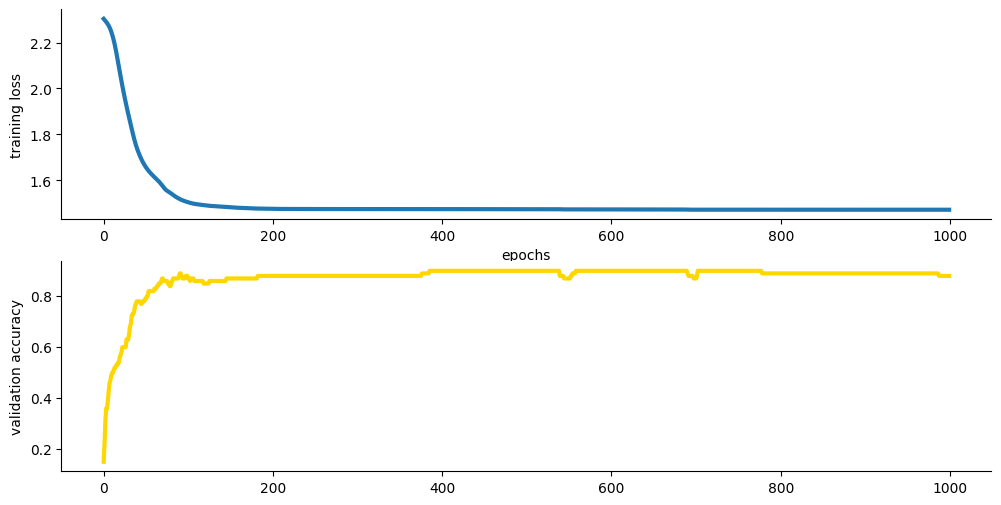

In [87]:
# Visualize training loss

plt.figure(figsize = (12, 6))

# Visualize training loss with respect to iterations (1 iteration -> single batch)
plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("epochs")
sns.despine()

# Visualize validation accuracy with respect to epochs
plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
sns.despine()

In [101]:
# Compute the testing accuracy 
with torch.no_grad() :
    # gets predictions
    y_pred_test = model(mnist_test_features)
    # finds index of highest probability in each sample, representing predicted class, compared with test_targets/true labels
    correct = (torch.argmax(y_pred_test, dim=1) == mnist_test_targets).type(torch.FloatTensor)
    # average of correct predictions
    print("Testing accuracy: " + str(correct.mean().numpy()))

Testing accuracy: 0.91


In [2]:
# Plot 5 incorrectly classified testing samples and print the model predictions for each of them
# You can use np.reshape() to convert flattened 1D array back to 2D array
print(mnist_pred_features.shape)
 
 
 
filter_mnist_pred_features = torch.argmax(mnist_pred_features, dim=1)
 
x = 1

# iterates through first 100 samples to check if predicted labe doesnt match with true label
for i in range(100):
    if filter_mnist_pred_features[i] != mnist_test_targets[i]:
        # prints real and predicted labels for miscalssificed images
        print(filter_mnist_pred_features[i], mnist_test_targets[i])
        # reshapes array into 28x28 and plots
        image = np.reshape(mnist_test_features[i].numpy(), (28, 28))
        plt.subplot(3, 4, x)
        plt.imshow(image, cmap='Greys')
        x += 1
        if x == 6:
            break
 
plt.show()

NameError: name 'mnist_pred_features' is not defined